In [15]:
!pip install -U nltk

In [16]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.meteor_score import meteor_score
import skimage.transform

In [59]:
nltk.download('wordnet',"/root/nltk-data")

[nltk_data] Downloading package wordnet to /root/nltk-data...


True

In [57]:
nltk.download("all-corpora")

[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /usr/share/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data] 

True

In [18]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [19]:
set_seed(42)

In [20]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

In [21]:
!wget www.cse.iitb.ac.in/~gowthamsridhar/data.zip

--2023-11-27 16:05:08--  http://www.cse.iitb.ac.in/~gowthamsridhar/data.zip
Resolving www.cse.iitb.ac.in (www.cse.iitb.ac.in)... 103.21.127.134
Connecting to www.cse.iitb.ac.in (www.cse.iitb.ac.in)|103.21.127.134|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.iitb.ac.in/~gowthamsridhar/data.zip [following]
--2023-11-27 16:05:08--  https://www.cse.iitb.ac.in/~gowthamsridhar/data.zip
Connecting to www.cse.iitb.ac.in (www.cse.iitb.ac.in)|103.21.127.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1113116819 (1.0G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.04G  8.43MB/s    in 2m 38s  

2023-11-27 16:07:48 (6.71 MB/s) - ‘data.zip’ saved [1113116819/1113116819]



In [22]:
!unzip data.zip

Archive:  data.zip
  inflating: flickr8k/captions.txt   
  inflating: flickr8k/images/1000268201_693b08cb0e.jpg  
  inflating: flickr8k/images/1001773457_577c3a7d70.jpg  
  inflating: flickr8k/images/1002674143_1b742ab4b8.jpg  
  inflating: flickr8k/images/1003163366_44323f5815.jpg  
  inflating: flickr8k/images/1007129816_e794419615.jpg  
  inflating: flickr8k/images/1007320043_627395c3d8.jpg  
  inflating: flickr8k/images/1009434119_febe49276a.jpg  
  inflating: flickr8k/images/1012212859_01547e3f17.jpg  
  inflating: flickr8k/images/1015118661_980735411b.jpg  
  inflating: flickr8k/images/1015584366_dfcec3c85a.jpg  
  inflating: flickr8k/images/101654506_8eb26cfb60.jpg  
  inflating: flickr8k/images/101669240_b2d3e7f17b.jpg  
  inflating: flickr8k/images/1016887272_03199f49c4.jpg  
  inflating: flickr8k/images/1019077836_6fc9b15408.jpg  
  inflating: flickr8k/images/1019604187_d087bf9a5f.jpg  
  inflating: flickr8k/images/1020651753_06077ec457.jpg  
  inflating: flickr8k/images/1022

In [23]:
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

In [24]:
list_of_files = os.listdir(input_dir)

# Preprocessing Images

In [25]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [26]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [27]:
Images = preprocess_images(input_dir)
Images.size()

torch.Size([8091, 3, 224, 224])

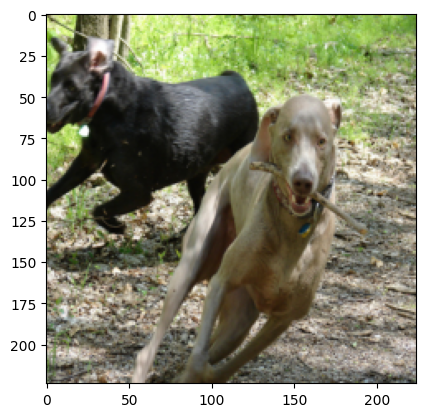

In [28]:
display_image(Images,1)

# Preprocessing Captions

In [29]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [30]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [31]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [32]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [33]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [34]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [35]:
train_split = int(0.8*len(list_of_files))
val_split = (len(list_of_files) - train_split)

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:,:,:,:]

In [36]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [37]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> man driving four-wheeler off-road <end>', '<start> man riding an atv makes jump over dirt road <end>', '<start> racer on an atv leaves the ground in jump <end>', '<start> person wearing helmet on four wheeled bike in air <end>', '<start> the man does trick on the fourwheeler <end>']


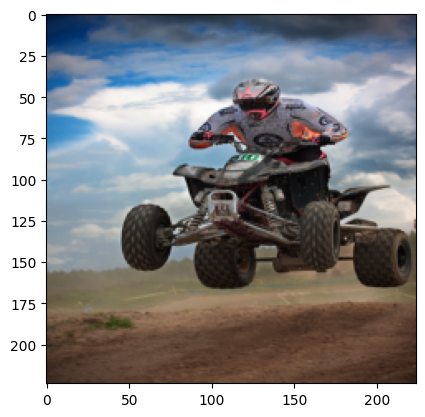

In [38]:
print(train_captions[0])
display_image(train_images,0)

In [39]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7827
6472
6472


# Captions Dataset

In [40]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [41]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [42]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

# CNN encoder part of the model

In [43]:
class CNN_model_1(nn.Module):
    def __init__(self):
        super(CNN_model_1,self).__init__()
        vgg=models.vgg19(pretrained=True)
        for p in vgg.parameters():
            p.requires_grad_(False)
        modules=list(vgg.children())[:-2]
        self.vgg=nn.Sequential(*modules)
    def forward(self,images):
        features=self.vgg(images)
        features=features.permute(0,2,3,1)
        features=features.view(features.size(0),-1,features.size(-1))
#         print(features.shape)
        return features #(batch_size,49,2048)

# LSTM and Transformer part of the decoder

In [44]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention,self).__init__()
        self.U=nn.Linear(512,512)
        self.W=nn.Linear(512,512)
        self.v=nn.Linear(512,1)
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(1)

    def forward(self,features,hidden_states):
        U_hidden=self.U(hidden_states)#(batch_size,512)
        W_features=self.W(features)#(batch_size,49,512)
        attention=self.tanh(U_hidden.unsqueeze(1)+W_features)
        e=self.v(attention).squeeze(2) #(batch_size,1)
        alpha=self.softmax(e)
        context=(features*alpha.unsqueeze(2)).sum(1)
        return alpha,context

In [45]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention()
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)  
        seq_length = len(captions[0])-1
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds,alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  
        alphas = []
        word = torch.tensor(vocab[1]['<start>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            if vocab[0][predicted_word_idx.item()] == "<end>":
                break
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        return " ".join([vocab[0][idx] for idx in captions]),alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

# Integrating the 2 parts of the model

In [46]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs,alpha = self.decoder(features,captions)
    return features,outputs,alpha

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.generate_captions(features)
    return prediction


In [53]:
def validate(model):
  actual_captions = []
  generated_captions = []
  total_meteor_score = 0
  for data in val_loader:
    image, caption_set = data
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab)[0].split())
    total_meteor_score += round(meteor_score(actual_captions[-1],generated_captions[-1]),4)
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  total_meteor_score /= len(generated_captions)
#   bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  print(f'Meteor_score:{total_meteor_score}')
  return total_meteor_score

In [54]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_score = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for i,(img,cap,caplen) in tqdm(enumerate(train_loader)):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs,alpha = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap[:,1:].reshape(-1))
                loss.backward()
                optimizer.step()
                count += 1
                average_loss += loss.item()
                perp = np.exp(loss.item())
            average_loss = average_loss/count
            averge_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, average_perp))
            score = validate(model)
            if score > best_score:
              print("checkpointing best model")
              best_checkpoint_model = model
              best_score = score
      return model,best_checkpoint_model

# Calling Functions

In [49]:
learning_rate = 0.0003
num_epochs = 1
embed_size=300
hidden_size=512
attention_size = 256
vocab_size=len(vocab[0])
n_layers=2

In [50]:
# decoder = (embed_size,hidden_size,vocab_size,n_layers)
decoder = DecoderRNN(embed_size,vocab_size,attention_size,512,hidden_size)
encoder = CNN_model_1()
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 251MB/s]  


In [51]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [60]:
best_checkpoint_model,final_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 1)

6472it [02:56, 36.65it/s]


Epoch [1/1], Loss: 3.7835, Perplexity: 0.0000


LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [ ]:
best_checkpoint_model,final_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 5)

# Generating Captions

In [ ]:
def visualize_att(image, words, alphas, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    T = transforms.ToPILImage()
    image = T(image.squeeze())
#     image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [ ]:
def generate_captions_for_random_image(model):
    index = np.random.choice(len(validation_images),1,replace = True)
    image = validation_images[index,:,:,:]
    captions,alphas = model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab)
    print(captions)
    visualize_att(image, caption, alphas, rev_word_map, smooth=True)
    

In [ ]:
generate_captions_for_random_image(model)

In [ ]:
generate_captions_for_random_image(model)

In [ ]:
generate_captions_for_random_image(model)

In [ ]:
generate_captions_for_random_image(model)

In [ ]:
generate_captions_for_random_image(model)

In [ ]:
generate_captions_for_random_image(model)